In [1]:
from typing import List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline

from functions.cleaner import clean_numeric_features
from functions.pipeline import balance_with_resample, create_pipeline

# Загрузка данных
df_train = pd.read_csv("train.csv")
print("Shape:", df_train.shape)
print("Columns:", df_train.columns.tolist())
num_features = ["age", "balance", "day", "duration", "campaign", "pdays", "previous"]

Shape: (750000, 18)
Columns: ['id', 'age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']


# Построение гистрограмм

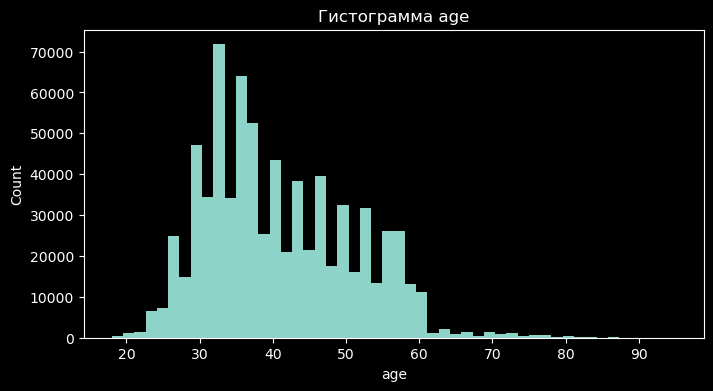

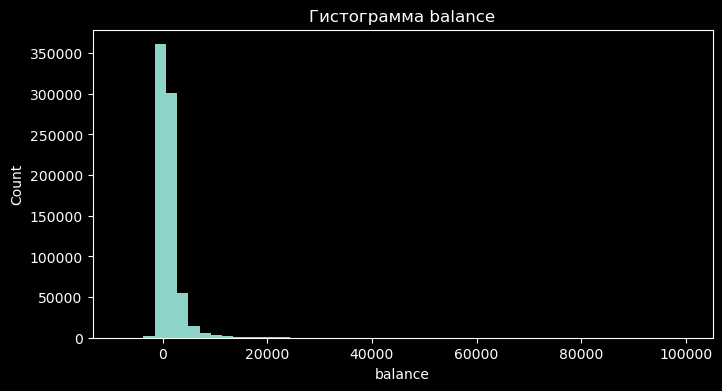

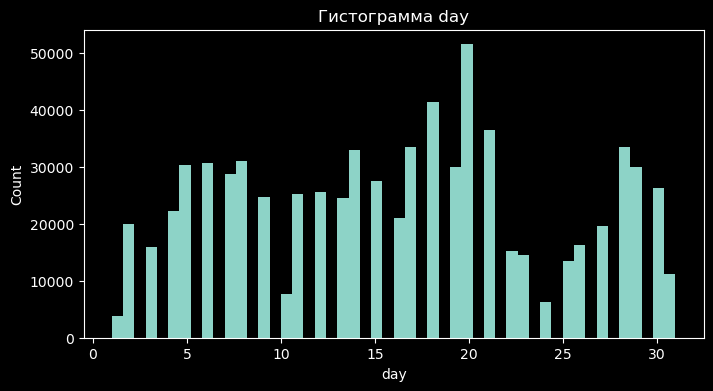

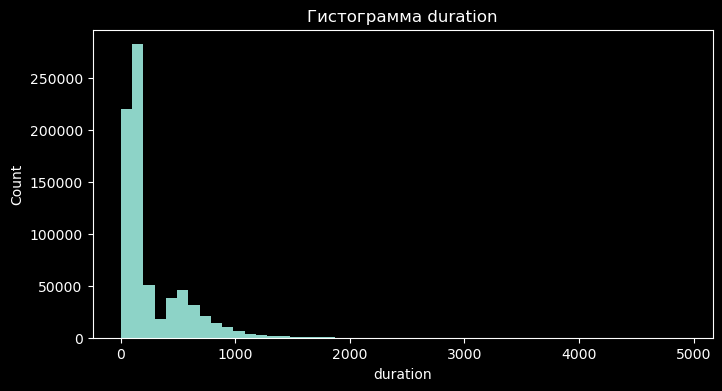

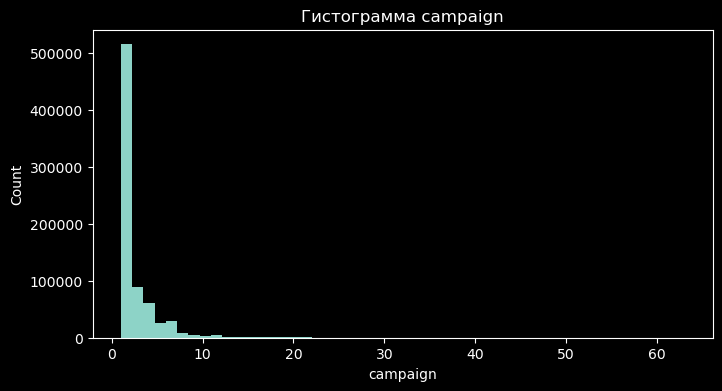

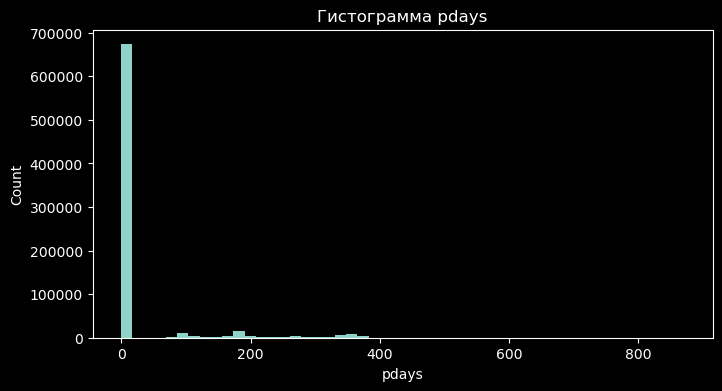

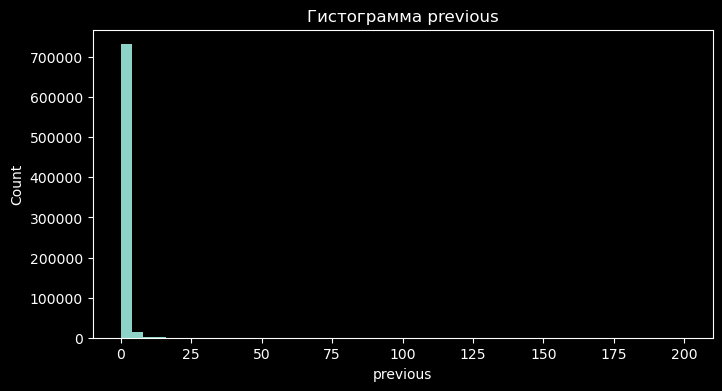

In [2]:
for col in num_features:
    plt.figure(figsize=(8, 4))
    df_train[col].hist(bins=50)
    plt.title(f"Гистограмма {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.grid(False)
    plt.show()

# Очистка

In [3]:
df_train = clean_numeric_features(df=df_train)

iso = IsolationForest(contamination=0.01, random_state=42)  # 1% выбросов
yhat = iso.fit_predict(df_train[num_features])
df_train = df_train[yhat == 1]


ee = EllipticEnvelope(contamination=0.01, random_state=42)
yhat = ee.fit_predict(df_train[num_features])
df_train = df_train[yhat == 1]


lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
yhat = lof.fit_predict(df_train[num_features])
df_train = df_train[yhat == 1]


print(df_train)

/Users/admin/anaconda3/envs/financial_project_env/lib/python3.13/site-packages/sklearn/covariance/_robust_covariance.py:185: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (24.688832078462621 > -5.357879827699300). You may want to try with a higher value of support_fraction (current value: 0.503).
  warnings.warn(
/Users/admin/anaconda3/envs/financial_project_env/lib/python3.13/site-packages/sklearn/covariance/_robust_covariance.py:185: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (25.066722542364225 > -2.330147109067191). You may want to try with a higher value of support_fraction (current value: 0.503).
  warnings.warn(
/Users/admin/anaconda3/envs/financial_project_env/lib/python3.13/site-packages/sklearn/covariance/_robust_covariance.py:185: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (25.084965139692901 > -0.818939119420882). You ma

            id  age          job  marital  education default  balance housing  \
0            0   42   technician  married  secondary      no        7      no   
1            1   38  blue-collar  married  secondary      no      514      no   
2            2   36  blue-collar  married  secondary      no      602     yes   
3            3   27      student   single  secondary      no       34     yes   
4            4   26   technician  married  secondary      no      889     yes   
...        ...  ...          ...      ...        ...     ...      ...     ...   
749992  749992   56     services  married  secondary      no     2089     yes   
749994  749994   31    housemaid   single  secondary      no      594      no   
749995  749995   29     services   single  secondary      no     1282      no   
749997  749997   50  blue-collar  married  secondary      no      217     yes   
749998  749998   32   technician  married  secondary      no     -274      no   

       loan   contact  day 

# Балансировка классов

In [7]:
X_train = df_train.drop(columns=["y"])
y_train = df_train["y"]

print("До балансировки:")
print(y_train.value_counts(normalize=True))

X_bal, y_bal = balance_with_resample(X_train, y_train, method="over")

print("\nПосле балансировки:")
print(y_bal.value_counts(normalize=True))

До балансировки:
y
0    0.894012
1    0.105988
Name: proportion, dtype: float64

После балансировки:
y
0    0.5
1    0.5
Name: proportion, dtype: float64


In [8]:
y_train = (y_bal == 1).astype(int)
X_train = X_bal.copy()


print("Unique values in y_train:", np.unique(y_train))
print("Value counts in y_train:\n", pd.Series(y_train).value_counts(normalize=True))


if "id" in X_train.columns:
    X_train = X_train.drop("id", axis=1)

# 7. Проверяем наличие всех фичей
cat_features = [
    "job",
    "marital",
    "education",
    "default",
    "housing",
    "loan",
    "contact",
    "month",
    "poutcome",
]


missing_features = [f for f in num_features + cat_features if f not in X_train.columns]
if missing_features:
    raise ValueError(f"Missing features in X_train: {missing_features}")

Unique values in y_train: [0 1]
Value counts in y_train:
 y
0    0.5
1    0.5
Name: proportion, dtype: float64


# Настройка моделей

In [ ]:
models: List[
    Tuple[
        str, Union[LogisticRegression, RandomForestClassifier, CatBoostClassifier], bool
    ]
] = [
    (
        "LogisticRegression",
        LogisticRegression(random_state=42, max_iter=1000, class_weight="balanced"),
        True,
    ),
    (
        "RandomForest",
        RandomForestClassifier(
            n_estimators=50,
            max_depth=12,
            max_features="sqrt",
            class_weight="balanced",
            n_jobs=-1,
            random_state=42,
        ),
        False,
    ),
    (
        "CatBoost",
        CatBoostClassifier(
            random_state=42,
            iterations=2000,
            early_stopping_rounds=100,
            verbose=0,
            auto_class_weights="Balanced",
        ),
        False,
    ),
]

In [12]:
for model_name, model, use_splines in models:
    print(f"\n=== Оценка модели {model_name} ===")
    pipeline: Pipeline = create_pipeline(model, num_features, cat_features, use_splines)

    split_success: bool = False
    for rs in [42, 123, 456, 777, 0]:
        X_train_split, X_val, y_train_split, y_val = train_test_split(
            X_train,
            y_train,
            test_size=0.2,
            stratify=y_train,
            random_state=rs,
            shuffle=True,
        )
        if len(np.unique(y_train_split)) >= 2 and len(np.unique(y_val)) >= 2:
            print(f"Разделение успешно с random_state={rs}")
            print("Классы в train_split:", np.unique(y_train_split))
            print("Классы в val:", np.unique(y_val))
            split_success = True
            break
        info_break = f"Разделение не удалось с rs={rs}"
        info_train_classes = f"train_classes={np.unique(y_train_split)}, "
        info_val_classes = f"val_classes={np.unique(y_val)}"
        print(f"{info_break}, {info_train_classes} {info_val_classes}")

    if split_success:
        pipeline.fit(X_train_split, y_train_split)
        y_pred: np.ndarray = pipeline.predict(X_val)
        y_pred_proba: np.ndarray = pipeline.predict_proba(X_val)[:, 1]
        print("\nОтчет по классификации:")
        print(classification_report(y_val, y_pred))
        print(f"AUC-ROC: {roc_auc_score(y_val, y_pred_proba):.4f}")
    else:
        print("Разделение не удалось — кросс-валидация.")
        cv: StratifiedKFold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores: np.ndarray = cross_val_score(
            pipeline, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1
        )
        print(f"Результаты кросс-валидации AUC-ROC: {cv_scores}")
        print(f"Средний AUC-ROC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    pipeline.fit(X_train, y_train)
    df_test: pd.DataFrame = pd.read_csv("test.csv")
    X_test: pd.DataFrame = df_test.drop("id", axis=1)
    test_predictions: np.ndarray = pipeline.predict_proba(X_test)[:, 1]
    submission: pd.DataFrame = pd.DataFrame(
        {"id": df_test["id"], "y": test_predictions}
    )
    submission.to_csv(f"{model_name}_submission.csv", index=False)
    print(f"Файл с предсказаниями для {model_name} создан!")

print("\nВсе модели обучены и предсказания сохранены!")


=== Оценка модели LogisticRegression ===
Разделение успешно с random_state=42
Классы в train_split: [0 1]
Классы в val: [0 1]

Отчет по классификации:
              precision    recall  f1-score   support

           0       0.91      0.86      0.88    126165
           1       0.86      0.91      0.89    126165

    accuracy                           0.88    252330
   macro avg       0.89      0.88      0.88    252330
weighted avg       0.89      0.88      0.88    252330

AUC-ROC: 0.9476
Файл с предсказаниями для LogisticRegression создан!

=== Оценка модели RandomForest ===
Разделение успешно с random_state=42
Классы в train_split: [0 1]
Классы в val: [0 1]

Отчет по классификации:
              precision    recall  f1-score   support

           0       0.95      0.84      0.89    126165
           1       0.86      0.95      0.90    126165

    accuracy                           0.90    252330
   macro avg       0.90      0.90      0.90    252330
weighted avg       0.90      0.90 